In [1]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
import vb_lib.structure_optimization_lib as str_opt_lib

import paragami
import vittles

from copy import deepcopy

import argparse
import distutils.util

import os

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 4000
n_loci = 200
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

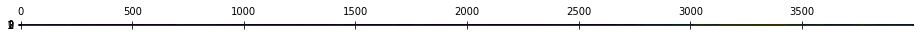

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs.shape

(4000, 200, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
k_approx = 12

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (200, 12, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (4000, 11, 2) (lb=0.0, ub=inf)


## Initialize 

In [11]:
t0 = time.time()
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                use_logitnormal_sticks)

print('init time: {:.03f}sec'.format(time.time() - t0))

vb_params_init_dict = deepcopy(vb_params_dict)

init time: 0.828sec


# Run CAVI

In [12]:
vb_svi_cavi, ez_opt_cavi, kl_vec_cavi, time_vec_cavi = \
    cavi_lib.run_cavi(g_obs, deepcopy(vb_params_init_dict), 
                        prior_params_dict,
                        use_logitnormal_sticks, 
                        max_iter = 20,
                        x_tol = 1e-2)


iteration [1]; kl:1751365.308491; elapsed: 6.9902secs
iteration [2]; kl:1400992.951642; elapsed: 7.1065secs
iteration [3]; kl:1283874.250429; elapsed: 7.041secs
iteration [4]; kl:1208707.166545; elapsed: 6.9317secs
iteration [5]; kl:1158359.747169; elapsed: 7.0015secs
iteration [6]; kl:1130452.471345; elapsed: 7.3126secs
iteration [7]; kl:1116185.082702; elapsed: 6.6291secs
iteration [8]; kl:1108283.155788; elapsed: 6.6519secs
iteration [9]; kl:1103318.93067; elapsed: 6.5816secs
iteration [10]; kl:1099840.199077; elapsed: 6.6331secs
iteration [11]; kl:1097207.356997; elapsed: 6.4782secs
iteration [12]; kl:1095111.500179; elapsed: 6.4479secs
iteration [13]; kl:1093385.573348; elapsed: 6.2334secs
iteration [14]; kl:1091929.16935; elapsed: 6.2992secs
iteration [15]; kl:1090676.608963; elapsed: 6.653secs
iteration [16]; kl:1089582.287202; elapsed: 6.7725secs
iteration [17]; kl:1088613.269931; elapsed: 6.7078secs
iteration [18]; kl:1087745.112872; elapsed: 6.6761secs
iteration [19]; kl:1086

# Run stochastic CAVI

In [13]:
e_z_init = cavi_lib.get_ez_from_vb_params_dict(g_obs, vb_params_dict, use_logitnormal_sticks)

In [14]:
vb_svi_dict, ez_opt_svi, kl_vec_svi, time_vec_svi = \
    cavi_lib.run_svi(g_obs, deepcopy(vb_params_init_dict),
                prior_params_dict,
                e_z_init,
                use_logitnormal_sticks,
                batchsize = round(n_obs / 10),
                x_tol = 1e-2,
                max_iter = 200,
                print_every = 10, 
                local_x_tol = 1e16)

iteration [10]; kl:1821590.77555; elapsed: 6.3417secs
iteration [20]; kl:1393367.997714; elapsed: 6.1573secs
iteration [30]; kl:1220208.481529; elapsed: 6.1633secs
iteration [40]; kl:1152125.267276; elapsed: 6.1454secs
iteration [50]; kl:1130150.872868; elapsed: 6.1568secs
iteration [60]; kl:1115299.491024; elapsed: 6.1426secs
iteration [70]; kl:1106370.706707; elapsed: 6.1965secs
iteration [80]; kl:1102293.565202; elapsed: 6.1791secs
iteration [90]; kl:1099506.56252; elapsed: 6.1868secs
iteration [100]; kl:1097652.382999; elapsed: 6.1622secs
iteration [110]; kl:1096136.949431; elapsed: 6.2482secs
iteration [120]; kl:1094882.208224; elapsed: 6.26secs
iteration [130]; kl:1093821.234046; elapsed: 6.1531secs
iteration [140]; kl:1092909.056172; elapsed: 6.1846secs
iteration [150]; kl:1092105.175898; elapsed: 6.1935secs
iteration [160]; kl:1091399.526208; elapsed: 6.1666secs
iteration [170]; kl:1090772.219237; elapsed: 6.1839secs
iteration [180]; kl:1090202.413293; elapsed: 6.1602secs
itera

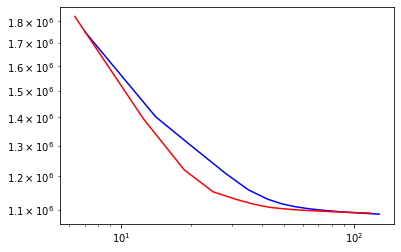

In [15]:
plt.loglog(time_vec_cavi[1:], kl_vec_cavi, 'b')
plt.loglog(time_vec_svi[1:], kl_vec_svi, 'r')

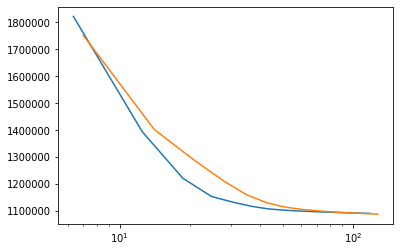

In [16]:
plt.semilogx(time_vec_svi[1:], kl_vec_svi)
plt.semilogx(time_vec_cavi[1:], kl_vec_cavi)

In [ ]:
def benchmark_one_cavi_cycle(n_obs, n_loci, n_pop, k_approx, run_cavi,  
                                vb_params_dict = None): 
    # draw data 
    g_obs, _, _ = \
        data_utils.draw_data(n_obs, n_loci, n_pop)
    
    # get prior 
    prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

    prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)
    
    # set vb_params
    use_logitnormal_sticks = False
    _, vb_params_paragami = \
        structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                        use_logitnormal_sticks = use_logitnormal_sticks)
    
    if vb_params_dict is None: 
        vb_params_dict = vb_params_paragami.random()
    
    
    if run_cavi: 
        _, _, _, time_vec = \
            cavi_lib.run_cavi(g_obs, deepcopy(vb_params_dict), 
                                prior_params_dict,
                                use_logitnormal_sticks, 
                                max_iter = 2,
                                f_tol = -1, 
                                x_tol = 1e-2)
    else: 
        # run svi 
        _ = cavi_lib.run_svi(g_obs, deepcopy(vb_params_dict),
                prior_params_dict,
                e_z_init = np.random.rand((n_obs, n_loci, k_approx + 1, 2)),
                use_logitnormal_sticks = use_logitnormal_sticks,
                batchsize = 1,
                x_tol = 1e-2,
                max_iter = 2,
                print_every = 1)
        
    return time_vec[1], vb_params_dict